In [1]:
import covasim


import covasim.utils as cvu

from importlib import reload

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import covasibyl


import sys

Covasim 3.0.7 (2021-06-29) — © 2021 by IDM


/home/fmazza/env/covasim/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from covasim import settings as cvsets

cvsets.set_option("show", False)

In [3]:
from covasibyl.rankers import dotd_rank, tracing_rank, mean_field_rank

## Run Sim with rankers

In [4]:
pars_sim={"pop_type":"hybrid",#"pop_type":"synthpops",
          "location":"UK",
          "n_days":100, 
          "pop_size":20_000,
          "pop_infected":5,
          "rand_seed":3,
          "rescale":False,
         }

pars_sim_test = dict(pars_sim)
#pars_sim_test["n_days"] = 60
pars_sim_test["dynam_layer"] = {k:1 for k in ["w","c"]}
#pars_sim_test["rand_seed"] = 5

In [5]:
sim_test = covasim.Sim(pars=pars_sim_test)

sim_test.run()

sim_test.pars["beta"]

Initializing sim with 20000 people for 100 days
Loading location-specific data for "UK"
  Running 2020-03-01 ( 0/100) (0.98 s)  ———————————————————— 1%
  Running 2020-03-11 (10/100) (1.27 s)  ••—————————————————— 11%
  Running 2020-03-21 (20/100) (1.58 s)  ••••———————————————— 21%
  Running 2020-03-31 (30/100) (1.91 s)  ••••••—————————————— 31%
  Running 2020-04-10 (40/100) (2.28 s)  ••••••••———————————— 41%
  Running 2020-04-20 (50/100) (2.65 s)  ••••••••••—————————— 50%
  Running 2020-04-30 (60/100) (3.01 s)  ••••••••••••———————— 60%
  Running 2020-05-10 (70/100) (3.40 s)  ••••••••••••••—————— 70%
  Running 2020-05-20 (80/100) (3.79 s)  ••••••••••••••••———— 80%
  Running 2020-05-30 (90/100) (4.19 s)  ••••••••••••••••••—— 90%
  Running 2020-06-09 (100/100) (4.54 s)  •••••••••••••••••••• 100%

Simulation summary:
   17043 cumulative infections
       0 cumulative reinfections
   16918 cumulative infectious
   11631 cumulative symptomatic cases
    1082 cumulative severe cases
     398 

0.016

In [6]:
covasim.options.set("show",0)

In [7]:
covasim.options

#0. verbose:        0.1
#1. show:           0
#2. close:          0
#3. backend:        'module://matplotlib_inline.backend_inline'
#4. interactive:    True
#5. dpi:            72
#6. font_size:      10
#7. font_family:    ['sans-serif']
#8. precision:      32
#9. numba_parallel: 'none'
#10. numba_cache:    True
#11. set:            <function set_option at 0x7f89f3796310>
#12. get_default:    <function get_default at 0x7f89f37963a0>
#13. help:           <function get_help at 0x7f89f3796430>

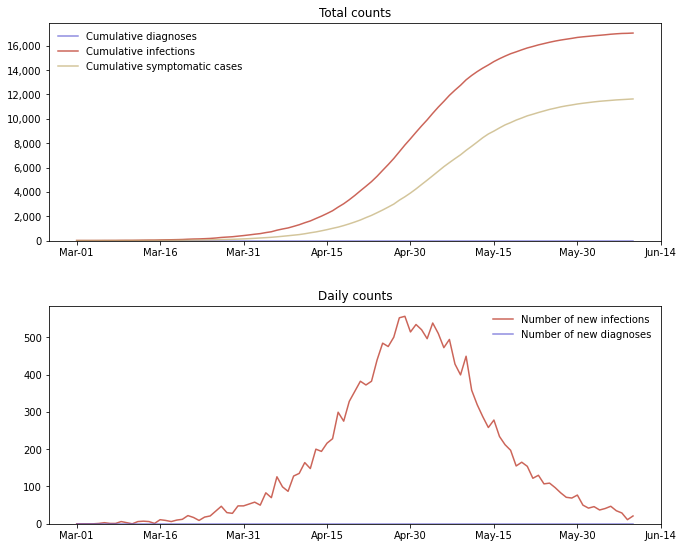

In [8]:
_=sim_test.plot(to_plot={"Total counts":["cum_diagnoses", "cum_infections", "cum_symptomatic"], "Daily counts":["new_infections","new_diagnoses"]})

In [9]:
sim_test.people.infectious_by_variant

array([[False, False, False, ..., False, False, False]])

In [10]:
beta=0.016

In [11]:
no_quar_red = {
    "quar_factor":dict(zip(["h","s","c","w"],[1.]*4))
}

In [12]:
full_iso_pars={
     'iso_factor': {'h': 0., 's': 0., 'w': 0., 'c': 0.},
}

In [14]:
import covasibyl.ranktest as rktest
reload(sys.modules["covasibyl.tester"])
reload(rktest)

<module 'covasibyl.ranktest' from '/home/fmazza/projects/covasim_integration/interventions/covasibyl/ranktest.py'>

In [27]:
sp = dict(pars_sim_test)
sp.update(no_quar_red)

In [15]:
import sib

In [16]:
from scipy.special import expit

In [17]:
from covasibyl import utils
reload(utils)

<module 'covasibyl.utils' from '/home/fmazza/projects/covasim_integration/interventions/covasibyl/utils.py'>

In [18]:
from covasibyl.rankers import sib_rank
reload(sib_rank)

<module 'covasibyl.rankers.sib_rank' from '/home/fmazza/projects/covasim_integration/interventions/covasibyl/rankers/sib_rank.py'>

In [29]:
ct = covasim.contact_tracing(trace_probs=.4, trace_time=1, start_day=10)

In [19]:
pars_nov0=(1.21533407, 3.87484739)
pars_vlow=(1.04475749, 5.97047953)

T = pars_sim["n_days"]

values_vload= [1.53846, 0.76923]

u0 = expit(pars_nov0[0]*(range(T+1) - pars_nov0[1]*np.ones(T+1)))
u1 = expit(pars_vlow[0]*(range(T+1) - pars_vlow[1]*np.ones(T+1)))

vact = u0*values_vload[0]+(values_vload[1]-values_vload[0])*u1

gamma_p=(11.40049704552924, 0.8143055827103249)

def divmax(x):
    return x/max(x)

rec_dist = utils.gamma_pdf_full(np.arange(0,T+1), *gamma_p)

prob_i = sib.PiecewiseLinear(sib.RealParams(
    list((vact*beta))))
prob_r = sib.PiecewiseLinear(sib.RealParams(
    list(1-rec_dist.cumsum()) ))

In [20]:
N = pars_sim["pop_size"]
prob_seed = 1/N
prob_sus = 0.5
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1e-6
fp_rate = 0.0
fn_rate = 0.0
sibPars = sib.Params(
        prob_i=prob_i,#sib.Uniform(beta), #prob_i,
        prob_r=prob_r, #sib.Exponential(0.06), #prob_r,
        pseed=pseed,
        psus=psus,
        pautoinf=pautoinf)


In [24]:
class dummy_logger:
    def info(self,s):
        print(s)

In [21]:
reload(sib_rank)

<module 'covasibyl.rankers.sib_rank' from '/home/fmazza/projects/covasim_integration/interventions/covasibyl/rankers/sib_rank.py'>

In [25]:
import logging
sibRanker = sib_rank.SibRanker(
    params=sibPars,
    maxit0=15,
    maxit1=20,
    tol=1e-3,
    memory_decay=1e-5,
    window_length=21,
    tau=0,
    fnr=fn_rate,
    fpr=fp_rate

)
sibRkTest = rktest.RankTester(sibRanker, "sib ranker",
                              num_tests_algo=400,
                              num_tests_rand=200,
                              symp_test=20.,
                              start_day=10,
                              logger=dummy_logger(),
                             )
sib.set_num_threads(26)

In [30]:
sim_ranker_sib = covasim.Sim(pars=sp, interventions=[sibRkTest, ct], label="sib rk interv")#interv,ct,

In [ ]:
sim_ranker_sib.run()

Initializing sim with 20000 people for 100 days
Loading location-specific data for "UK"
Note: you have defined a contact tracing intervention but no testing intervention was found. Unless this is intentional, please define at least one testing intervention.
  Running "sib rk interv": 2020-03-01 ( 0/100) (1.65 s)  ———————————————————— 1%
sib.iterate(damp=0):  2/15 6.661e-16/0.001    
sib.iterate(damp=0.5):  0/20 1.554e-15/0.001    
winBP: (S,I,R): (19999.0, 1.0, 0.0), seeds: 1.0, ll: -13862.4
sib.iterate(damp=0):  2/15 4.457e-09/0.001    
sib.iterate(damp=0.5):  0/20 3.109e-15/0.001    
winBP: (S,I,R): (19999.0, 1.0, 0.0), seeds: 1.0, ll: -13862.4
sib.iterate(damp=0):  2/15 3.443e-08/0.001    
sib.iterate(damp=0.5):  0/20 3.209e-11/0.001    
winBP: (S,I,R): (19998.9, 1.1, 0.0), seeds: 1.0, ll: -13862.4
sib.iterate(damp=0):  2/15 1.612e-07/0.001    
sib.iterate(damp=0.5):  0/20 5.166e-10/0.001    
winBP: (S,I,R): (19998.8, 1.2, 0.0), seeds: 1.0, ll: -13862.4
sib.iterate(damp=0):  2/15 5.

In [ ]:
rkInter = sim_ranker_sib.get_interventions()[0]

In [ ]:
pi = lambda : sib.PiecewiseLinear(ranker.params.prob_i, T+2)
pr = lambda : sib.PiecewiseLinear(ranker.params.prob_r, T+2) 
fg = sib.FactorGraph(params=ranker.params, 
                     individuals=[(i, ranker.params.prob_i, ranker.params.prob_r, pi(), pr())
                                  for i in range(N)])

In [ ]:
conts_m = utils.get_contacts_day(sim_ranker_sib.people)
## remove contacts that are isolated (tested)
tested_iso = cvu.true(sim_ranker_sib.people.diagnosed)
conts_m = utils.filt_contacts_df(conts_m, tested_iso, 0.1, N)

conts_m["day"] = 4
contacts_day = conts_m[["i","j","day","m"]].to_records(index=False)


In [ ]:
%%time
for c in contacts_day:
    fg.append_contact(*c)

In [ ]:
import numba as nb

In [ ]:
@nb.njit()
def add_contacts(contacts, fg):
    for c in contacts:
        fg.append_contact(*c)

In [ ]:
conts_m

In [ ]:
sim_ranker.get_interventions()[0].prepare_export()

In [ ]:
sim_ranker.save("MF_sim.sim")

In [ ]:
f =sim_ranker.plot(to_plot={
                          "Infectious": ["n_infectious","n_dead"],
                        "Testing":["n_diagnosed", "n_quarantined"],
                         },fig_args=dict(figsize=(8,6)), log_scale=True)
"""
_=sim_ct.plot(to_plot={
                          "Infectious": ["n_infectious","n_dead"],
                        "Testing":["n_diagnosed", "n_quarantined"],
                         },fig=f)
"""

In [ ]:
intervk = sim_ranker.get_interventions()[0]

In [ ]:
sim_ranker.get_interventions()[0].prepare_export()

In [ ]:
diff= (sim_ranker.people.diagnosed.astype(int) - intervk.tester.diagnosed.astype(int))

In [ ]:
diff[diff!=0]

In [ ]:
(sim_ranker.people.date_diagnosed < 100).nonzero()

In [ ]:
((intervk.tester.date_diagnosed < 100) & np.logical_not(sim_ranker.people.date_diagnosed < 100)).nonzero()

In [ ]:
conts_m = cvrank.get_contacts_day(sim_ranker.people)
conts_m["day"] = 2
#contacts_day = [(i,j,day, val) for i,j,val in zip(conts_m.row, conts_m.col, conts_m.data)]
#contacts_day = conts_m[["i","j","day","m"]].to_records(index=False)

In [ ]:
%%timeit 
 conts_m[["i","j","day","m"]].to_records(index=False)

In [ ]:
%%timeit 

tuple(zip(conts_m.i, conts_m.j, conts_m.day, conts_m.m))

In [ ]:
plt.plot(sim_ct.results["n_diagnosed"].values/sim_ct.results["n_infectious"].values)
plt.plot(sim_ranker.results["n_diagnosed"].values/sim_ranker.results["n_infectious"].values)
#["variant"]["n_infectious_by_variant"]
#plt.yscale("log")

In [ ]:
plt.plot(sim_ct.results["n_quarantined"])
plt.plot(sim_ranker.results["n_quarantined"])
plt.yscale("log")

In [ ]:
k="n_infectious"
plt.plot(sim_test.results[k], "--", color="black")

plt.plot(sim_ct.results[k])
plt.plot(sim_ranker.results[k])
plt.plot(sim_ranker_ct.results[k])

plt.yscale("log")

In [ ]:
k="n_quarantined"
plt.plot(sim_test.results[k], "--", color="black")

#plt.plot(sim_ct.results[k])
plt.plot(sim_ranker.results[k])
#plt.plot(sim_ranker_ct.results[k])
plt.plot(sim_ranker_sib.results[k])

plt.yscale("log")

In [ ]:
o=(sim_ranker.results["n_alive"])
o.index

In [ ]:
np.save("sim_MF_results", sim_ranker.results["cum_infections"], allow_pickle=False)

In [ ]:
sibPars.fakeobs

In [ ]:
np.load("sim_MF_results.npy")

In [ ]:
k="cum_infections"
plt.plot(sim_test.results[k], "--", color="black")

plt.plot(sim_ct.results[k])
plt.plot(sim_ranker.results[k])
plt.plot(sim_ranker_ct.results[k])
plt.plot(sim)

plt.hlines(sp["pop_size"], 0, 100, ls="--",color="red")
plt.yscale("log")

In [ ]:
k="cum_infections"
plt.plot(sim_test.results[k], "--", color="black")

plt.plot(sim_ct.results[k])
plt.plot(sim_ranker.results[k])
plt.plot(sim_ranker_ct.results[k])

plt.hlines(sp["pop_size"], 0, 100, ls="--",color="red")
plt.yscale("log")

In [ ]:
k="cum_severe"
plt.plot(sim_test.results[k], "--", color="black")

plt.plot(sim_ct.results[k])
plt.plot(sim_ranker.results[k])
plt.plot(sim_ranker_ct.results[k])

plt.hlines(sp["pop_size"], 0, 100, ls="--",color="red")
plt.yscale("log")